## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [0]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dropout(0.25)(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dropout(0.25)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.95)
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [0]:
batch_size = 512
epochs = 50
early_stops = [10, 25]
monit = ['val_loss', 'acc']

In [138]:
import time

results = {}

countdown = len(early_stops) * len(monit)

for i, stops in enumerate(early_stops):
  for monitor in monit:
        
        # Setup callbacks
        earlystop = keras.callbacks.EarlyStopping(monitor=monitor, patience=stops, verbose=1)
        
        # Build/train model
        t0 = time.time()
        model = build_mlp(x_train.shape[1:])
        print(f'Countdown: {countdown}, Monitor: {monitor}, early_stop: {stops}')
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[earlystop], verbose=1, shuffle=True, validation_data=(x_test, y_test))
        t1 = time.time()
        
        print(f'time: {t1 - t0} sec')
        
        # Collecting accuracy/loss
        train_loss = history.history['loss']
        test_loss = history.history['val_loss']
        train_acc = history.history['acc']
        test_acc = history.history['val_acc']
        
        tag = "early_stop %s" %(str(stops))
        results[tag] = {"train_loss": train_loss,
                        "test_loss": test_loss,
                        "train_acc": train_acc,
                        "test_acc": test_acc
                       }
        countdown -= 1

Countdown: 4, Monitor: val_loss, early_stop: 10
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 363us/step - loss: 2.4557 - acc: 0.2379 - val_loss: 1.9260 - val_acc: 0.3472
Epoch 2/50
50000/50000 [==============================] - 13s 254us/step - loss: 2.0154 - acc: 0.3191 - val_loss: 1.7485 - val_acc: 0.3821
Epoch 3/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.8813 - acc: 0.3498 - val_loss: 1.7050 - val_acc: 0.3906
Epoch 4/50
50000/50000 [==============================] - 13s 250us/step - loss: 1.7986 - acc: 0.3692 - val_loss: 1.6328 - val_acc: 0.4213
Epoch 5/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.7382 - acc: 0.3859 - val_loss: 1.6218 - val_acc: 0.4259
Epoch 6/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.6955 - acc: 0.3992 - val_loss: 1.5786 - val_acc: 0.4374
Epoch 7/50
50000/50000 [==============================] - 12s 250us/

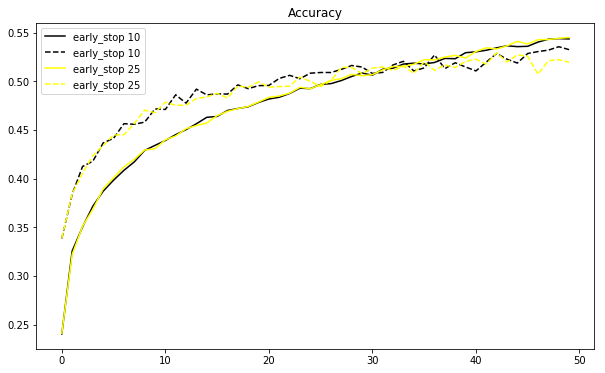

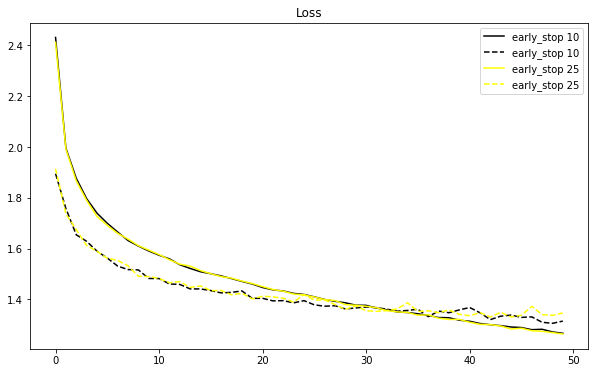

In [139]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(results))]

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(results[cond]['train_acc'], '-', label=cond, color=colors[i])
    plt.plot(results[cond]['test_acc'], '--', label=cond, color=colors[i])
plt.title("Accuracy")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=colors[i])
    plt.plot(range(len(results[cond]['test_loss'])),results[cond]['test_loss'], '--', label=cond, color=colors[i])
plt.title("Loss")
plt.legend(loc="upper right")
plt.show()